# American Football and Machine Learning 
#### netids: cfr59, jh

**Overview:**

**Dataset:** https://bit.ly/2pVfEDI

**Research Goal:** 

**Methodologies/Approach:**

In [1]:
# import the necessary libraries & modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import seaborn as sns
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.linear_model import Perceptron

# configure settings
pd.set_option('display.max_columns', 100)

Using TensorFlow backend.


In [2]:
# import the data
nfl_data = pd.read_csv('nfl_ml.csv', low_memory = False)

## Data Manipulation

In [3]:
# drop entirely irrelevant columns (based on our discretion)
nfl_data.drop(['GameId', 'PlayId', 'JerseyNumber', 'Season', 'DisplayName', \
               'NflIdRusher', 'Stadium', 'Week', 'Location', 'NflId', \
               'PlayerCollegeName'], axis=1, inplace=True);

#### Number Conversions

In [4]:
# time remaining into seconds
def clock(str):
    return int(str[:2]) * 60 + int(str[3:5])

nfl_data['GameClock'] = nfl_data['GameClock'].apply(clock)

In [5]:
# player height into inches
def height(str):
    return int(str[:1]) * 12 + int(str[2:])

nfl_data['PlayerHeight'] = nfl_data['PlayerHeight'].apply(height)

In [6]:
# time difference between snap and handoff in seconds
nfl_data['TimeSnap'] = nfl_data['TimeSnap'].replace({'T':' ', 'Z':''}, regex=True) 
nfl_data['TimeHandoff'] = nfl_data['TimeHandoff'].replace({'T':' ', 'Z':''}, regex=True) 

def time_delta(row):
    d1 = datetime.datetime.strptime(row['TimeSnap'], '%Y-%m-%d %H:%M:%S.%f')
    d2 = datetime.datetime.strptime(row['TimeHandoff'], '%Y-%m-%d %H:%M:%S.%f')
    return int(d2.strftime('%S')) - int(d1.strftime('%S'))
    
nfl_data['time_delta'] = nfl_data.apply(lambda row: time_delta(row), axis=1)

In [7]:
# calculate the player's approximate age (only takes year into consideration)
age = []
for i in range(len(nfl_data)):
    d1 = datetime.datetime.strptime(nfl_data['TimeSnap'][i], '%Y-%m-%d %H:%M:%S.%f')
    y = int(d1.strftime('%Y'))
    a = y - int(str(nfl_data['PlayerBirthDate'][i])[-4:])
    age.append(a)
    
nfl_data['ApproxAge'] = age

In [8]:
# make all windspeed values numeric
nfl_data['WindSpeed'] = (pd.to_numeric(nfl_data['WindSpeed'],errors='coerce').fillna(0))

#### String Encoding

In [9]:
def encode(col, d={}):
    '''
    Returns a dictionary that maps column
    to order of occurrence
    '''
    dct = d
    value = 0
    for i in range(len(nfl_data)):
        key = nfl_data[col][i]
        if key not in dct.keys():
            dct.update({key : value})
            value += 1
    
    return dct      

In [10]:
cols = ['Team',  \
       'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'Position', \
       'PlayDirection', 'OffenseFormation', 'OffensePersonnel', 'DefensePersonnel']

for c in cols:
    nfl_data[c].replace(encode(c), inplace=True)

In [11]:
# team dictionary so that teams map to same number over separate columns 
d1 = encode('PossessionTeam')
d2 = encode('FieldPosition', d1)
d3 = encode('HomeTeamAbbr', d2)
d4 = encode('VisitorTeamAbbr', d3)

teams = d4

cols = ['PossessionTeam', 'FieldPosition', 'HomeTeamAbbr', 'VisitorTeamAbbr']

for c in cols:
    nfl_data[c].replace(teams, inplace=True)

In [12]:
# remove remaining unnecessary columns
nfl_data.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1, inplace=True)

# replace NaN values with 0
nfl_data.fillna(0, inplace=True)

## Data Visualization

## Machine Learning

In [13]:
def print_metrics(predictions, actual):
    
    exact_accuracy = accuracy_score(predictions, y_test)
    one_yard_accuracy = sum(abs(predictions - y_test) <= 1) / predictions.size
    two_yard_accuracy = sum(abs(predictions - y_test) <= 2) / predictions.size
    avg_error = (predictions - y_test).sum() / predictions.size
    
    count = 0
    for i in range(predictions.size):
        if predictions[i] >= 0 and y_test.iloc[i] >= 0 or \
        predictions[i] <= 0 and y_test.iloc[i] <= 0:
            count += 1
    forward_backward_accuracy = count / predictions.size

    print('Precision with 0 yard buffer: ', exact_accuracy)
    print('Precision with 1 yard buffer: ', one_yard_accuracy)
    print('Precision with 2 yard buffer: ', two_yard_accuracy)
    print('Precision when estimating forward/backward direction: ', forward_backward_accuracy)
    print('Average Error: ', avg_error)

In [14]:
X = nfl_data.drop(['Yards'], axis = 1)
Y = nfl_data['Yards']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1)

In [16]:
accuracy = []
for k in range(1, 101):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train[:10000], y_train[:10000])
    predictions = model.predict(x_test)
    accuracy.append(accuracy_score(predictions, y_test))

#print_metrics(predictions, y_test)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
[0.10277697130436829, 0.10296529374377163, 0.09748040269614959, 0.09256832573504602, 0.0930234382969374, 0.09627984714495336, 0.1000149088597861, 0.10218846368123288, 0.10490344551596426, 0.1065826539339773, 0.1071711615571127, 0.108073539912587, 0.10873266845049866, 0.1100744658312474, 0.11005877229463046, 0.11070220729592517, 0.11167520656617572, 0.11295422980045668, 0.1136839792531446, 0.11332302791095487, 0.1131739393130939, 0.11394292260732418, 0.1145000431572257, 0.11480606712125611, 0.11479037358463917, 0.11569275194011347, 0.11553581657394402, 0.1160772435872286, 0.11647742877096068, 0.11623417895339805, 0.1165558964540454, 0.11680699303991651, 0.11722287176026554, 0.11762305694399762, 0.117

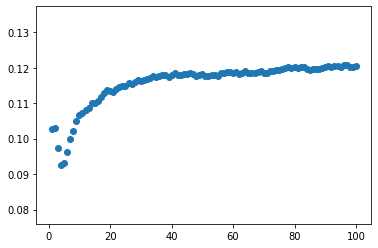

In [19]:
plt.scatter(range(1, 101), accuracy )
plt.show()

Based on this model

In [20]:
model = Perceptron() #Create the Perceptron Model
model.fit(x_train, y_train) # Train the Perceptron Model
predictions = model.predict(x_test)
print_metrics(predictions, y_test)

Precision with 0 yard buffer:  0.028311140056967537
Precision with 1 yard buffer:  0.08222628510447973
Precision with 2 yard buffer:  0.1372949050933373
Precision when estimating forward/backward direction:  0.4991721659434562
Average Error:  -3.828728588130978
